In [2]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
from enlib import enmap, lensing as enlensing
import numpy as np
from orphics import maps,io,stats,cosmology,lensing
from szar import counts

In [7]:
theory_file_root = "../../bayesian-cluster/input/planck_srini"
planck_cosmo = {'As':2.14e-9,'omch2': 0.1188,'ombh2':0.02230,'H0':67.74,'tau':0.066,'ns':0.9667,'mnu':0.,'w0':-1} 

cc = counts.ClusterCosmology(planck_cosmo,skipCls=True)
theory = cosmology.loadTheorySpectraFromCAMB(theory_file_root,unlensedEqualsLensed=False,useTotal=False,TCMB = 2.7255e6,lpad=9000,get_dimensionless=False)

# Cluster params
mass = 1.3548e14 # is actually 2e14 M/h in planck cosmology
conc = 3.0
overdensity = 200
critical = True
atclusterz = True
z = 0.7

#mass = 2e14
#conc = 3.2
#overdensity = 180
#critical = False
#atclusterz = False
#z = 0.7


# Experiment

noise = 10.0
beam = 1.0

# Template
width_arcmin = 15.
px_res_arcmin = 0.5
shape,wcs = maps.rect_geometry(width_arcmin=width_arcmin,px_res_arcmin=px_res_arcmin)
modrmap = enmap.modrmap(shape,wcs)
modlmap = enmap.modlmap(shape,wcs)



# N
kbeam = maps.gauss_beam(beam,modlmap)

def get_ncov(inoise):
    noise_uK_rad = inoise*np.pi/180./60.
    normfact = np.sqrt(np.prod(enmap.pixsize(shape,wcs)))
    noise_uK_pixel = noise_uK_rad/normfact
    return np.diag([(noise_uK_pixel)**2.]*np.prod(shape))
Ncov = get_ncov(noise)
n2d = (noise*np.pi/180./60.)**2.+modlmap*0.
ngen = maps.MapGen(shape,wcs,n2d.reshape((1,1,shape[0],shape[1])))

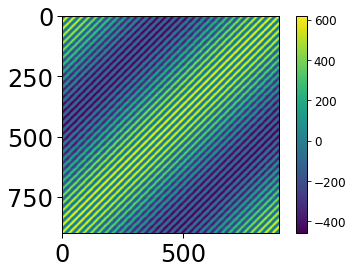

In [8]:
power2d = theory.uCl('TT',modlmap)
bfcov = maps.diagonal_cov(power2d)
ny,nx = shape                     
Ucov = maps.pixcov(shape,wcs,bfcov)
Ucov = enmap.enmap(Ucov.reshape(np.prod(shape),np.prod(shape)),wcs)
io.plot_img(Ucov)
mgen = maps.MapGen(shape,wcs,power2d.reshape((1,1,shape[0],shape[1])))

In [9]:
print(Ucov.shape)

(900, 900)


In [10]:
def lcov(imass):
    lens_order = 5                    
    posmap = enmap.posmap(shape,wcs)
    
    # kappa
    kappa = lensing.nfw_kappa(imass,modrmap,cc,overdensity=overdensity,critical=critical,atClusterZ=atclusterz,zL=z)

    
    phi,_ = lensing.kappa_to_phi(kappa,modlmap,return_fphi=True)
    grad_phi = enmap.grad(phi)    
    pos = posmap + grad_phi      
    alpha_pix = enmap.sky2pix(shape,wcs,pos, safe=False) 
    scov = lensing.lens_cov(Ucov,alpha_pix,lens_order=lens_order,kbeam=kbeam,bshape=shape)  
    return scov

In [11]:
scov = lcov(mass)

In [12]:
step = mass*0.1
scov_up = lcov(mass+step/2.)
scov_dn = lcov(mass-step/2.)
dcov = (scov_up-scov_dn)/step


In [13]:
#print(np.linalg.cond( scov ))
#print(np.linalg.cond( scov + Ncov))
tcov = scov + Ncov
#io.plot_img(tcov)
#print(np.linalg.cond( tcov))


In [14]:
#from scipy.linalg import pinv2                                                                                                                       
#s,logdet = np.linalg.slogdet(tcov)
#cinv = pinv2(tcov)

#io.plot_img(cinv)


In [15]:
dcov_dict= {}
dcov_dict['mass'] = dcov
fid_params_dict = {}
fid_params_dict['mass'] = mass
tcov = scov + Ncov
foqe = stats.OQE(tcov,dcov_dict,fid_params_dict,invert=False,deproject=True)

In [16]:
merr = foqe.sigma()['mass']
N = 1000
msn = mass/merr*np.sqrt(N)
print(msn)

13.279822383554356


In [17]:
sns = []
noises = [10.,7.,5.,3.,1.,0.5,0.1]
for noise in noises:
    print(noise)
    Ncov = get_ncov(noise)    
    tcov = scov + Ncov #+ 5000
    foqe = stats.OQE(tcov,dcov_dict,fid_params_dict)
    sns.append(mass/foqe.sigma()['mass']*np.sqrt(1000.))


10.0
7.0
5.0
3.0
1.0
0.5
0.1


In [18]:
tellmax = 8000
pellmax = 8000
deg = 5.
px = 0.5
dell = 10
kellmin = 10
kellmax = 8096
mshape,mwcs = maps.rect_geometry(width_deg = deg, px_res_arcmin=px)

theory_file_root = "../../alhazen/data/Aug6_highAcc_CDM"
mtheory = cosmology.loadTheorySpectraFromCAMB(theory_file_root,unlensedEqualsLensed=False,useTotal=False,TCMB = 2.7255e6,lpad=9000,get_dimensionless=True)

bin_edges = np.arange(kellmin,kellmax,dell)
myNls = lensing.NlGenerator(mshape,mwcs,mtheory,bin_edges,gradCut=2000,bigell=9000,lensedEqualsUnlensed=False,unlensedEqualsLensed=False)

ells = np.arange(0,9000,1)
clkk = mtheory.gCl('kk',ells)

tellmin = 2
pellmin = 2
TCMB = 1.

beam = 1.0
snsMF = []
noises = [10.,7.,5.,3.,1.,0.5,0.1]
for noise in noises:

    
    myNls.updateNoise(beam,noise,noise,tellmin,tellmax,pellmin,pellmax)

    ls,ntt = myNls.getNl(polComb="TT",halo=True)

    arcStamp = 100.
    pxStamp = 0.05
    Nls = maps.interp(ells,clkk)(ls) + ntt
    snRet,k500,std = lensing.NFWMatchedFilterSN(cc,np.log10(mass),conc,z,ells=ls,Nls=Nls,kellmax=kellmax,overdensity=overdensity,critical=critical,atCluster\
Z=atclusterz,saveId=None,rayleighSigmaArcmin=None,arcStamp=arcStamp,pxStamp=pxStamp)

    snsMF.append(snRet*np.sqrt(1000.))
    print(beam,noise,mass,snRet*np.sqrt(1000.))

/direct/astro+u/msyriac/repos/orphics/orphics/lensing.py:722: RuntimeWarning: overflow encountered in multiply
  NL = l4 *alval/ 4.


1.0 10.0 1.3548e+14 16.65581068517763
1.0 7.0 1.3548e+14 20.81630162018062
1.0 5.0 1.3548e+14 25.595959351785535
1.0 3.0 1.3548e+14 34.52865112007747
1.0 1.0 1.3548e+14 57.786565016029165
1.0 0.5 1.3548e+14 69.62564794775926
1.0 0.1 1.3548e+14 78.29155623544183


[ 13.27982238  16.98146285  21.47344751  31.135215    68.80259063
 113.42391939 353.09909369]


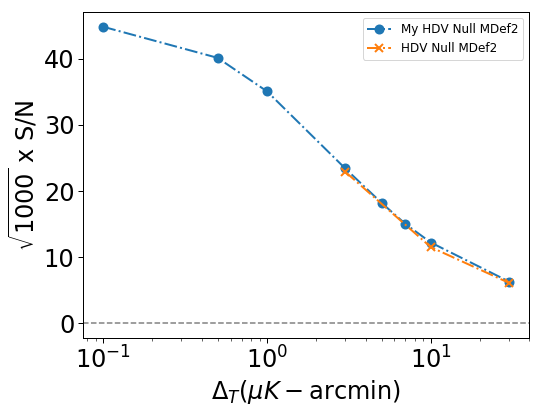

[ 13.27982238  16.98146285  21.47344751  31.135215    68.80259063
 113.42391939 353.09909369]


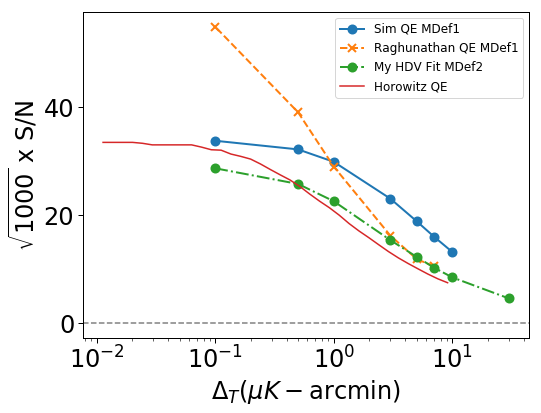

[ 13.27982238  16.98146285  21.47344751  31.135215    68.80259063
 113.42391939 353.09909369]


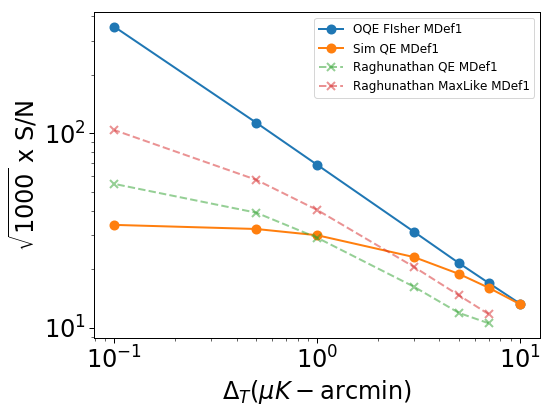

[ 13.27982238  16.98146285  21.47344751  31.135215    68.80259063
 113.42391939 353.09909369]


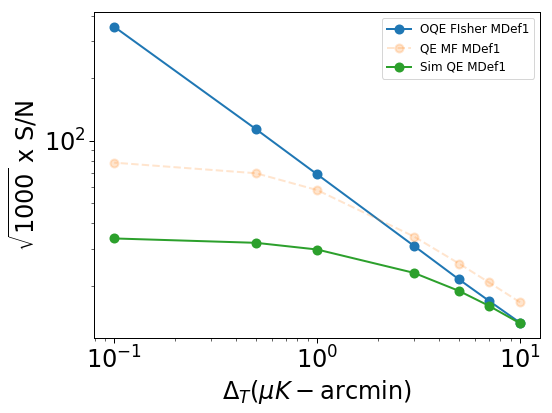

In [35]:
ns,merrs = np.loadtxt("../../bayesian-cluster/input/horowitz_fine.csv",delimiter=",",unpack=True)
sn_hors = 1./merrs


qesn = \
[54.90901676,
39.07056506,
29.01941776,
16.23952687,
11.90733869,
10.54165923]

mlsn = \
[103.8990549,
57.66774171,
40.32114719,
20.54065028,
14.66201689,
11.73662547]

myqe = \
[33.8,
32.2,
29.9,
23.08,
18.90,
16.05,
13.20]

hdv = [[3.,10.,30.],[22.9,11.5,6.1]]
my_hdv = [[0.1,0.5,1.,3.,5,7,10.,30.],[ \
44.8,
40.1,
35.04,
23.4,
18.2,
15,
12.2,
6.3]]
my_hdv_fit = [[0.1,0.5,1.,3.,5,7,10.,30.],[ \
28.7,
25.8,
22.6,
15.4,
12.3,
10.3,
8.5,
4.6]]

#my_hdv = [[0.1,0.5,1.,3.,5,7,10.,30.],[44.3,40,36,25.8,20,16.7,13.8,7.0]]
#my_hdv_fit = [[0.1,0.5,1.,3.,5,7,10.,30.],[29.2,26.3,23.7,17.2,13.6,11.5,9.5,5.2]]

# With ellmax=20000 for 0.1 uK'
#my_hdv = [[0.1,0.5,1.,3.,5,7,10.,30.],[45,40,36,25.8,20,16.7,13.8,7.0]]
#my_hdv_fit = [[0.1,0.5,1.,3.,5,7,10.,30.],[30,26.3,23.7,17.2,13.6,11.5,9.5,5.2]]

pl = io.Plotter(xscale="log",ylabel="$\\sqrt{1000}$ x S/N",xlabel="$\\Delta_T (\\mu K-\\mathrm{arcmin})$",figsize=(8,6)) #,yscale='log'
sns = np.array(sns)
print(sns)
pl.add(my_hdv[0],my_hdv[1],ls="-.",marker="o",label="My HDV Null MDef2",lw=2,markersize=8,mew=2)
pl.add(hdv[0],hdv[1],ls="-.",marker="x",label="HDV Null MDef2",lw=2,markersize=8,mew=2)
pl.hline()
pl.legend(loc='upper right',labsize=12)
pl.done()


pl = io.Plotter(xscale="log",ylabel="$\\sqrt{1000}$ x S/N",xlabel="$\\Delta_T (\\mu K-\\mathrm{arcmin})$",figsize=(8,6)) #,yscale='log'
sns = np.array(sns)
print(sns)
pl.add(noises,myqe[::-1],marker="o",label="Sim QE MDef1",lw=2,markersize=8,mew=2)
pl.add(noises[1:],qesn[::-1],marker="x",label="Raghunathan QE MDef1",lw=2,markersize=8,ls="--",mew=2)
#pl.add(my_hdv[0],my_hdv[1],ls="-.",marker="o",label="My HDV Null MDef2",lw=2,markersize=8,mew=2)
pl.add(my_hdv_fit[0],my_hdv_fit[1],ls="-.",marker="o",label="My HDV Fit MDef2",lw=2,markersize=8,mew=2)
#pl.add(hdv[0],hdv[1],ls="-.",marker="x",label="HDV Null MDef2",lw=2,markersize=8,mew=2)
pl.add(ns,sn_hors,label="Horowitz QE")
pl.hline()
pl.legend(loc='upper right',labsize=12)
pl.done()

pl = io.Plotter(xscale="log",ylabel="$\\sqrt{1000}$ x S/N",xlabel="$\\Delta_T (\\mu K-\\mathrm{arcmin})$",figsize=(8,6),yscale='log')
sns = np.array(sns)
print(sns)
pl.add(noises,sns,marker="o",label="OQE FIsher MDef1",lw=2,markersize=8,mew=2)
#pl.add(noises,snsMF,marker="o",label="QE MF MDef1",lw=2,markersize=8,mew=2)
pl.add(noises,myqe[::-1],marker="o",label="Sim QE MDef1",lw=2,markersize=8,mew=2)
pl.add(noises[1:],qesn[::-1],marker="x",label="Raghunathan QE MDef1",lw=2,markersize=8,ls="--",alpha=0.5,mew=2)
pl.add(noises[1:],mlsn[::-1],marker="x",label="Raghunathan MaxLike MDef1",lw=2,markersize=8,ls="--",alpha=0.5,mew=2)
#pl.add(hdv[0],hdv[1],ls="-.",marker="x",label="HDV Null MDef2",lw=2,markersize=8,mew=2)
#pl.add(my_hdv[0],my_hdv[1],ls="-.",marker="o",label="My HDV Null MDef2",lw=2,markersize=8,mew=2)
pl.hline()
pl.legend(loc='upper right',labsize=12)
pl.done()

pl = io.Plotter(xscale="log",ylabel="$\\sqrt{1000}$ x S/N",xlabel="$\\Delta_T (\\mu K-\\mathrm{arcmin})$",figsize=(8,6),yscale='log')
sns = np.array(sns)
print(sns)
pl.add(noises,sns,marker="o",label="OQE FIsher MDef1",lw=2,markersize=8,mew=2)
pl.add(noises,snsMF,marker="o",label="QE MF MDef1",lw=2,markersize=8,mew=2,alpha=0.2,ls="--")
pl.add(noises,myqe[::-1],marker="o",label="Sim QE MDef1",lw=2,markersize=8,mew=2)
pl.hline()
pl.legend(loc='upper right',labsize=12)
pl.done()

[ 10.02768373  14.34040504  19.85149705  31.49653911  70.52247671
 108.7017193  332.13927364]


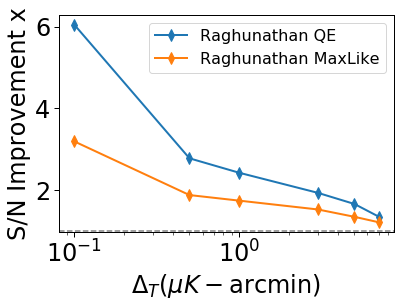

In [15]:

pl = io.Plotter(xscale="log",ylabel="S/N Improvement x",xlabel="$\\Delta_T (\\mu K-\\mathrm{arcmin})$")
sns = np.array(sns)
print(sns)
pl.add(noises[1:],sns[1:]/qesn[::-1],marker="d",label="Raghunathan QE",lw=2,markersize=8)
pl.add(noises[1:],sns[1:]/mlsn[::-1],marker="d",label="Raghunathan MaxLike",lw=2,markersize=8)
pl.legend(loc='upper right',labsize=16)
pl.hline(y=1.)
pl.done()

In [16]:
noise = 0.1

n2d = (noise*np.pi/180./60.)**2.+modlmap*0.
ngen = maps.MapGen(shape,wcs,n2d.reshape((1,1,shape[0],shape[1])))

Ncov = get_ncov(noise)
tcov = scov + Ncov
foqe = stats.OQE(tcov,dcov_dict,fid_params_dict,invert=False,deproject=True)

mass = 2.2e14
lens_order = 5
posmap = enmap.posmap(shape,wcs)
kappa = lensing.nfw_kappa(mass,modrmap,cc,overdensity=overdensity,critical=critical,atClusterZ=atclusterz,zL=z)
phi,_ = lensing.kappa_to_phi(kappa,modlmap,return_fphi=True)
grad_phi = enmap.grad(phi)    
pos = posmap + grad_phi
alpha_pix = enmap.sky2pix(shape,wcs,pos, safe=False) 


N = 1000
merrs = []
for i in range(N):
    if (i+1)%100==0: print(i+1)
    unlensed = mgen.get_map()      
    noise_map = ngen.get_map()      
    lensed = maps.filter_map(enlensing.displace_map(unlensed, alpha_pix, order=lens_order),kbeam)
    obs = lensed + noise_map
    
    dat = obs.ravel()
    dat -= dat.mean()
    merrs.append(foqe.estimate(dat)['mass'])

100
200
300
400
500
600
700
800
900
1000


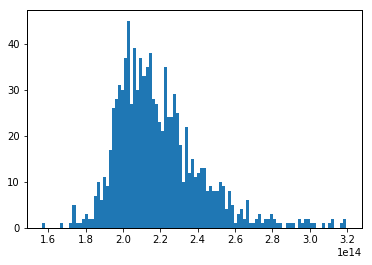

2.192532074129388
2.1473458858119487
1.5673575624073537
298.4728159262548


In [17]:
from scipy.stats import mode
merrs = np.array(merrs)
#io.plot_img(obs)
io.hist(merrs,bins=100)
print(merrs.mean()/1e14)
print(np.median(merrs)/1e14)
mv,cts = mode(merrs)
print(mv[0]/1e14)


print(merrs.mean()/merrs.std()*np.sqrt(1000.))